<a href="https://colab.research.google.com/github/MehrdadJalali-KIT/pySHACL/blob/master/GCNMOF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import networkx as nx
import pandas as pd
import os
from stellargraph import StellarGraph
import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
edges_all=pd.read_csv('/content/drive/MyDrive/MOF/MOFSMILES/List_METAL_6000.csv')
nodes_all=pd.read_csv('/content/drive/MyDrive/MOF/MOFSMILES/Features_1800_NOLABEL.csv')
  
nodes_all1=pd.read_csv('/content/drive/MyDrive/MOF/MOFSMILES/Features_1800.csv')
node_subjects=nodes_all1.iloc[:,10]

G = nx.Graph()
G = StellarGraph(nodes=nodes_all,edges=edges_all)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 1999, Edges: 48524

 Node types:
  default: [1999]
    Features: float32 vector, length 10
    Edge types: default-default->default

 Edge types:
    default-default->default: [48524]
        Weights: all 1 (default)
        Features: float32 vector, length 1


In [ ]:
import csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 1999, Edges: 48524

 Node types:
  default: [1999]
    Features: float32 vector, length 10
    Edge types: default-default->default

 Edge types:
    default-default->default: [48524]
        Weights: all 1 (default)
        Features: float32 vector, length 1


In [ ]:
set(node_subjects)

{0, 1, 2, 3}

In [ ]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.4, test_size=None, random_state=0,stratify=node_subjects
)

In [ ]:
from collections import Counter

Counter(train_subjects)

Counter({0: 424, 1: 169, 2: 108, 3: 98})

In [ ]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
test_targets = target_encoding.transform(test_subjects)

In [ ]:
batch_size = 5
num_samples = [10, 5]

In [ ]:
generator = GraphSAGENodeGenerator(G, batch_size, num_samples)

In [ ]:
train_gen = generator.flow(train_subjects, train_targets, shuffle=True)

In [ ]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
)

In [ ]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [ ]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
test_gen = generator.flow(test_subjects, test_targets)

In [ ]:
history = model.fit(
    train_gen, epochs=100, validation_data=test_gen, verbose=2, shuffle=False
)

Epoch 1/100
160/160 - 5s - loss: 1.2134 - acc: 0.5219 - val_loss: 1.1923 - val_acc: 0.5317 - 5s/epoch - 31ms/step
Epoch 2/100
160/160 - 2s - loss: 1.1980 - acc: 0.5307 - val_loss: 1.2086 - val_acc: 0.5317 - 2s/epoch - 13ms/step
Epoch 3/100
160/160 - 2s - loss: 1.1947 - acc: 0.5307 - val_loss: 1.1826 - val_acc: 0.5317 - 2s/epoch - 13ms/step
Epoch 4/100
160/160 - 2s - loss: 1.1855 - acc: 0.5307 - val_loss: 1.1742 - val_acc: 0.5317 - 2s/epoch - 13ms/step
Epoch 5/100
160/160 - 2s - loss: 1.1757 - acc: 0.5332 - val_loss: 1.1194 - val_acc: 0.5317 - 2s/epoch - 14ms/step
Epoch 6/100
160/160 - 2s - loss: 1.0874 - acc: 0.5782 - val_loss: 0.8836 - val_acc: 0.7183 - 2s/epoch - 13ms/step
Epoch 7/100
160/160 - 2s - loss: 0.9743 - acc: 0.6270 - val_loss: 0.7840 - val_acc: 0.6542 - 2s/epoch - 14ms/step
Epoch 8/100
160/160 - 2s - loss: 0.9973 - acc: 0.6345 - val_loss: 0.8392 - val_acc: 0.6567 - 2s/epoch - 13ms/step
Epoch 9/100
160/160 - 2s - loss: 0.9946 - acc: 0.6258 - val_loss: 0.7905 - val_acc: 0.65

240/240 [==============================] - 2s 7ms/step - loss: 0.5856 - acc: 0.8642

Test Set Metrics:
	loss: 0.5856
	acc: 0.8642


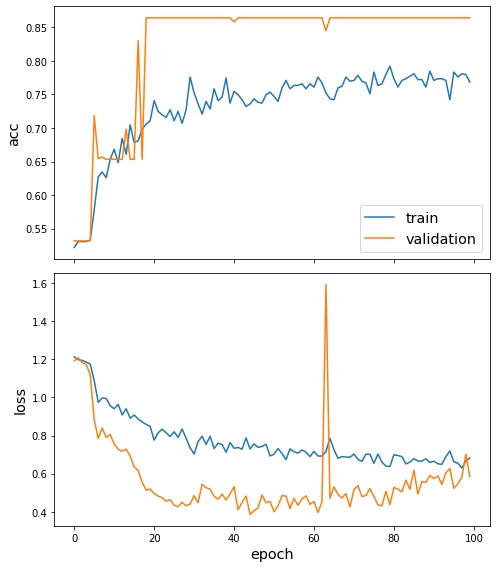

In [ ]:
sg.utils.plot_history(history)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

In [ ]:
all_nodes = node_subjects
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

In [ ]:
node_predictions = target_encoding.inverse_transform(all_predictions)

In [ ]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(100)

,Predicted,True
0,1,1
1,1,1
2,1,1
3,0,0
4,1,1
...,...,...
95,1,2
96,0,0
97,0,0
98,1,2


In [ ]:
Gnx = G.to_networkx(feature_attr=None)

In [ ]:
for nid, pred, true in zip(df.index, df["Predicted"], df["True"]):
    Gnx.nodes[nid]["subject"] = true
    Gnx.nodes[nid]["PREDICTED_subject"] = pred.split("=")[-1]


Test Set Metrics:
	loss: 0.5856
	acc: 0.8642
[[1062    0    0    0]
 [   0  422    0    0]
 [   0  271    0    0]
 [   0    0    0  244]]


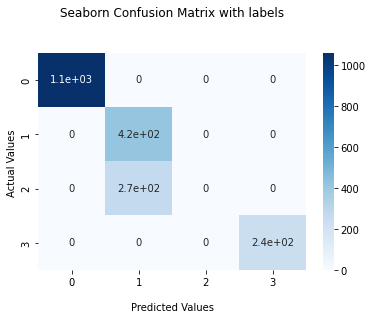

In [ ]:
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))
    

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


cf_matrix = confusion_matrix(node_subjects,node_predictions)
print(cf_matrix)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');



In [ ]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [ ]:
emb = embedding_model.predict(all_mapper)
emb.shape

(1999, 32)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

In [ ]:
X = emb
y = np.argmax(target_encoding.transform(node_subjects), axis=1)

In [ ]:
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_subjects.index)
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=node_subjects.index)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


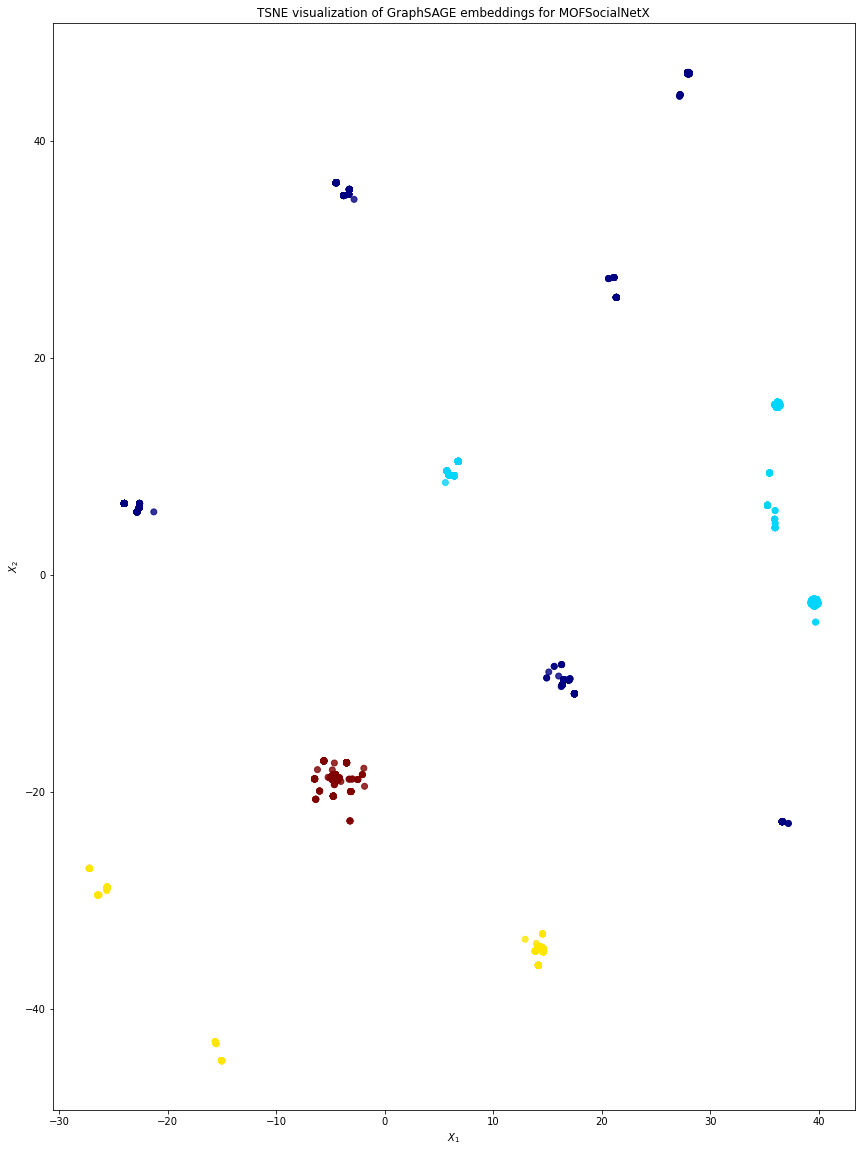

In [ ]:
alpha = 0.8

fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GraphSAGE embeddings for MOFSocialNetX".format(transform.__name__)
)
plt.show()

In [ ]:
for nid in train_subjects.index:
    Gnx.nodes[nid]["isTrain"] = True

for nid in test_subjects.index:
    Gnx.nodes[nid]["isTrain"] = False

In [ ]:
for nid in Gnx.nodes():
    Gnx.nodes[nid]["isCorrect"] = (
        Gnx.nodes[nid]["subject"] == Gnx.nodes[nid]["PREDICTED_subject"]
    )

KeyError: ignored

In [ ]:
pred_fname = "pred_n={}.graphml".format(num_samples)
nx.write_graphml(Gnx, os.path.join(dataset.data_directory, pred_fname))

In [ ]:
pip install stellargraph


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 435 kB 5.8 MB/s 
